https://www.pinecone.io/learn/series/image-search/zero-shot-image-classification-clip/

In [1]:
from transformers import CLIPProcessor, CLIPModel
import torch, numpy as np, os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.axes as axes

/home/jjzhao2/miniconda3/envs/cyclegan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def tokenize_labels(processor, text_batch, device):
  return processor(text=text_batch, padding=True, images=None, return_tensors='pt').to(device)

In [3]:
# Initialize models

model_id = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [29]:
classes = ["curvy stick", "straight stick"]
labels = [f"a photo of a {c}" for c in classes]
label_emb = model.get_text_features(**tokenize_labels(processor, labels, device))
label_emb = label_emb.detach().cpu().numpy()
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.shape

(2, 512)

In [30]:
folder_of_images = "pytorch-CycleGAN-and-pix2pix/results/pop-smoke-results/smoke-pop/test_latest/images"
first_few_paths = list(os.listdir(folder_of_images))
first_few_paths = list(filter(lambda x: x.endswith("fake_B.png"), first_few_paths))
first_few = [Image.open(os.path.join(folder_of_images, img_path)).convert("RGB") for img_path in first_few_paths]
len(first_few)

20

In [31]:
image = processor(
    text=None,
    images=first_few,
    return_tensors='pt'
)['pixel_values'].to(device)
img_emb = model.get_image_features(image)
img_emb.shape
img_emb = img_emb.detach().cpu().numpy()
img_emb = img_emb / np.linalg.norm(img_emb, axis=0)

In [32]:
scores = np.dot(img_emb, label_emb.T)
pred = np.argmax(scores, axis=1)
for i, v in enumerate(first_few_paths):
  print(f"[{i}] Img: {v}: {classes[pred[i]]}")
print(pred)
print(np.mean(pred))

[0] Img: 34_fake_B.png: deformed stick
[1] Img: 185_fake_B.png: deformed stick
[2] Img: 110_fake_B.png: deformed stick
[3] Img: 90_fake_B.png: deformed stick
[4] Img: 67_fake_B.png: deformed stick
[5] Img: 97_fake_B.png: popsicle stick
[6] Img: 143_fake_B.png: deformed stick
[7] Img: 164_fake_B.png: popsicle stick
[8] Img: 20_fake_B.png: popsicle stick
[9] Img: 58_fake_B.png: popsicle stick
[10] Img: 108_fake_B.png: popsicle stick
[11] Img: 157_fake_B.png: popsicle stick
[12] Img: 139_fake_B.png: popsicle stick
[13] Img: 170_fake_B.png: popsicle stick
[14] Img: 48_fake_B.png: popsicle stick
[15] Img: 98_fake_B.png: popsicle stick
[16] Img: 59_fake_B.png: popsicle stick
[17] Img: 118_fake_B.png: deformed stick
[18] Img: 32_fake_B.png: popsicle stick
[19] Img: 12_fake_B.png: deformed stick
[0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0]
0.6


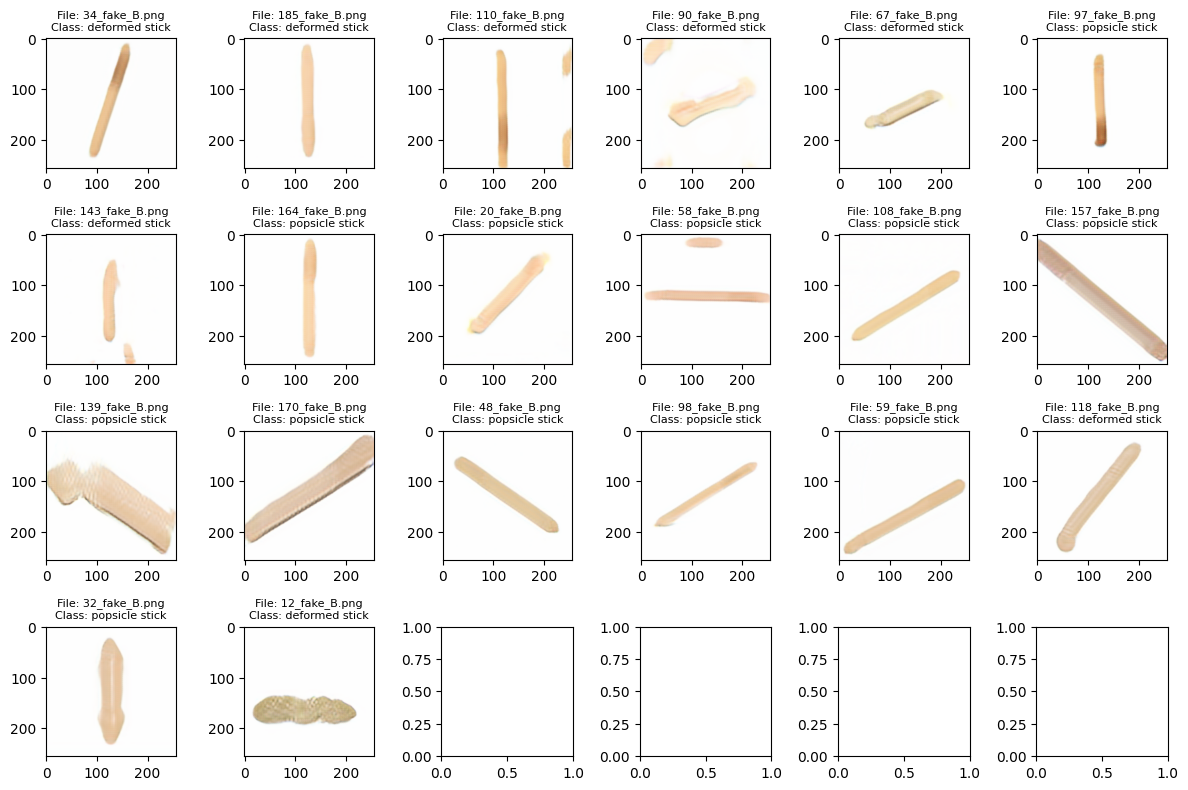

In [33]:
fig, axs = plt.subplots(4, 6, figsize=(12, 8))
axs = axs.flatten()
for i, path in enumerate(first_few_paths):
  ax = axs[i]
  ax: axes.Axes
  ax.imshow(first_few[i])
  ax.set_title(f"File: {first_few_paths[i]}\nClass: {classes[pred[i]]}", fontsize=8)
fig.tight_layout()